# Build RAG with Visual Grounding with IBM watsonx.ai, Docling & watsonx.data Milvus

## Introduction

**Retrieval-Augmented Generation (RAG)** enables large language models (LLMs) to fetch and utilize external knowledge, enhancing both **relevance** and **accuracy** in responses. In this notebook, we focus on building a **Visual Grounding RAG system**—designed to associate textual queries with visually structured document regions such as headers, tables and more.

Our pipeline will utilize **LangChain's Docling integration**, IBM's **watsonx.ai** platform, and **watsonx.data Milvus** to deliver a fast, layout-aware, and intelligent document search and answer generation system.

## Tech Stack Overview

### Docling (by IBM Research)
IBM’s open-source solution for intelligent document understanding:
- Converts rich documents into **structured hierarchical text**
- Preserves layout and visual context (e.g., headings, paragraphs, tables, figures)
- Ideal for tasks requiring **contextual grounding** or **visual-aware QA**


### Watsonx.data Milvus
IBM’s vector database offering:
- High-speed similarity search over large-scale dense embeddings
- Stores and indexes chunks produced by Docling
- Optimized for RAG scenarios with tight watsonx.ai integration


### IBM watsonx.ai
IBM’s enterprise-grade foundation model platform:
- Provides **embedding models** for generating dense vector representations
- Hosts **LLMs** for generating responses grounded in retrieved context
- Secure, scalable, and production-ready


By the end of this notebook, we'll have implemented a complete **Visual Grounding RAG system**—from document ingestion and structure-aware embedding to similarity search and natural language answer generation.

----


## 1.Install Dependencies
In this notebook, we are using **python==3.11.11** Please ensure you're using the same version in case you encounter any discrepancies

In [1]:
%pip install -q --progress-bar off --no-warn-conflicts langchain-docling langchain-core langchain_milvus langchain matplotlib pymilvus docling ibm-watsonx-ai 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2.Data Ingestion & Preparation with Docling

To build an effective Visual Grounding RAG pipeline, we first need to **ingest, convert, and structure** our source documents.

### 2.1 Configure the Docling PDF Converter

We initialize the `DocumentConverter` from Docling, specifying options such as:
- Enabling page image generation (useful for visual QA)
- Scaling images for better layout resolution

In [38]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=PdfPipelineOptions(
                generate_page_images=True,
                images_scale=2.0,
            ),
        )
    }
)

### 2.2 Convert PDFs and URLs to Docling JSON Format
We define a set of PDF sources (both local files and URLs can be used), convert each document to a Docling structured format, and save the outputs as .json files. These serve as intermediate hierarchical representations of each document.

In [39]:
from pathlib import Path
from tempfile import mkdtemp

# To use a local PDF, simply provide its path as a string, like: "path/to/local/file.pdf"
SOURCES = ["https://arxiv.org/pdf/2408.09869",
           "https://www.cs.purdue.edu/homes/csjgwang/pubs/SIGMOD21_Milvus.pdf",
           "https://arxiv.org/pdf/2206.01062"]

doc_store = {}
doc_store_root = Path(mkdtemp())
json_paths = []
for source in SOURCES:
    dl_doc = converter.convert(source=source).document
    file_path = Path(doc_store_root / f"{dl_doc.origin.binary_hash}.json")
    dl_doc.save_as_json(file_path)
    doc_store[dl_doc.origin.binary_hash] = file_path
    json_paths.append(file_path)

/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(


### 2.3 Load Document Chunks via LangChain DoclingLoader
Finally, we use DoclingLoader with ExportType.DOC_CHUNKS to extract hierarchical chunks of text from the structured JSONs. These chunks will be embedded and indexed for semantic retrieval.

In [40]:
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType

loader = DoclingLoader(
    file_path=SOURCES,
    converter=converter,
    export_type=ExportType.DOC_CHUNKS
)

docs = loader.load()

# Note: "Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512)..." This is a false alarm.

Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/docling/pipeline/standard_pdf_pipeline.py:262: RuntimeWarning: Mean of empty slice
  np.nanmean(
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.pyenv/versions/3.11.5/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encounter

In [41]:
for d in docs[:3]:
    print(f"- {d.page_content=}")
print("...")

- d.page_content='Docling Technical Report\nVersion 1.0\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar\nAI4K Group, IBM Research R¨ uschlikon, Switzerland'
- d.page_content='Abstract\nThis technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.'
- d.page_content='1 Introduction\nConverting PDF documents back into a machine-processable format has been a major challenge for deca

## 3.Vector generation/Embedding creation

### 3.1 Authentication Setup

In [42]:
from ibm_watsonx_ai import APIClient


# Set up WatsonX API credentials

my_credentials = {

"url": "<watsonx URL>",         # Replace with your your service instance url (watsonx URL)
"apikey": '<watsonx_api_key>'   # Replace with your watsonx_api_key 

}




client = APIClient(my_credentials)

### 3.2 Generate Dense Embeddings with WatsonX

Here, we configure the WatsonX embedding model (`SLATE_30M_ENGLISH_RTRVR`) and define token limits and response options.

In [43]:
from ibm_watsonx_ai.foundation_models.embeddings import Embeddings

from ibm_watsonx_ai.metanames import EmbedTextParamsMetaNames as EmbedParams

# Initialize the WatsonX client for embeddings

model_id = client.foundation_models.EmbeddingModels.SLATE_30M_ENGLISH_RTRVR

# Define embedding parameters

embed_params = {

    EmbedParams.TRUNCATE_INPUT_TOKENS: 128,  # Adjust token truncation as needed

    EmbedParams.RETURN_OPTIONS: {'input_text': True},

}

# Set up the embedding model

embedding = Embeddings(

    model_id=model_id,

    credentials=my_credentials,

    params=embed_params,

    project_id="<project_id>",  # Replace with your project ID

    space_id=None,

    verify=False

)



### 3.3 Verify Embedding Output

In [44]:
test_embedding = embedding.embed_query(text="This is a test")
embedding_dim = len(test_embedding)
print(embedding_dim)
print(test_embedding[:10])

384
[0.03725458, 0.030964559, 0.020786876, 0.0017769941, -0.0043248124, -0.0220291, 0.013955155, 0.013128637, -0.009391382, 0.005630895]


## 4.Store Embeddings in watsonx.data Milvus

To enable fast and accurate semantic search, we now store our document embeddings in **watsonx.data Milvus**, IBM's managed vector database. This step initializes a vector store from our Docling-extracted chunks and embeds them using the selected **watsonx.ai embedding model**.

Milvus will automatically:
- Generate dense vector embeddings from your chunks
- Store them in a named collection (`docling_demo`)
- Build an index for efficient similarity search (in this case, a **FLAT index** with **L2 distance**)

We also enable TLS connection and provide authentication parameters to securely connect to our Milvus instance.

In [45]:
import json
from pathlib import Path
from tempfile import mkdtemp

from langchain_milvus import Milvus

vectorstore = Milvus.from_documents(
    documents=docs,
    embedding=embedding,
    collection_name="docling_demo",
    index_params={
        "index_type": "FLAT",        # Type of index
        "metric_type": "L2"          # Required: distance metric
    },
     connection_args={
        "uri": "https://<hostname>:<port>", # Replace with your watsonx.data Milvus URI or IP
        "user":"<user>",
        "password":"<password>",
        "secure": True,  # Set True if TLS is enabled
        "server_pem_path": "/path_to_ca.cert"
    }, 
    drop_old=True
)


print("connected")

connected


## 5.Query, Generate Answers & Visualize with Visual Grounding

In this final stage, we perform the core of **retrieval-augmented generation (RAG)** using:

- **IBM watsonx.ai** for large language model (LLM) inference,  
- **LangChain** to orchestrate the RAG pipeline,  
- **Docling** for visual grounding and bounding-box-based highlighting of answers.

We define a custom prompt template, fetch the most relevant document chunks from Milvus, and pass them to the LLM for answer generation. Finally, we visualize the provenance of the answer using page-level image highlighting.



### 5.1 Set up watsonx.ai Language Model

We use ibm/granite-3-3-8b-instruct for answering the user query

In [46]:
from ibm_watsonx_ai.foundation_models import ModelInference
from langchain_ibm import WatsonxLLM

# Initialize model inference
model_inference = ModelInference(
    model_id="ibm/granite-3-3-8b-instruct",  # Use a watsonx.ai foundational model
     params={
        "max_new_tokens": 1024         
    },    
    credentials=my_credentials,
    project_id="<project_id>",  # Replace with your project ID
)

# Wrap with LangChain's WatsonxLLM
llm = WatsonxLLM(watsonx_model=model_inference)

### 5.2 Define Prompt, Setup Retriever & Execute RAG

In this step, we prepare the core RAG (Retrieval-Augmented Generation) logic:

- **Prompt Template**: A structured prompt is defined to instruct the LLM to generate a well-explained answer based on the retrieved context.
- **Retriever Setup**: We configure the Milvus vector store to return the top-3 relevant document chunks for the given query.
- **RAG Execution**: The retrieved documents are formatted and passed to the IBM watsonx.ai LLM to generate the final answer.



In [49]:
import json
import matplotlib.pyplot as plt
from PIL import ImageDraw
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from docling.chunking import DocMeta
from docling.datamodel.document import DoclingDocument


# --- Define Prompt ---
PROMPT_TEMPLATE = """Generate a summary of the context that answers the question. Explain the answer in multiple steps if possible. 
Answer style should match the context. Ideal Answer Length 5-12 sentences.

Context:
{context}

Question:
{question}

Answer:
"""

prompt = PromptTemplate(template=PROMPT_TEMPLATE, input_variables=["context", "question"])

# --- Setup Retriever ---
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# --- Helper Function ---
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def clip_text(text, threshold=100):
    return f"{text[:threshold]}..." if len(text) > threshold else text

# --- RAG Execution ---
query = "What is the Percentage of Train data for Section-header?"  # Replace with the query of your choice

docs = retriever.get_relevant_documents(query)
formatted_context = format_docs(docs)
response = llm.invoke(prompt.format(context=formatted_context, question=query))


### 5.3 Visualize Highlighted Context from Retrieved Documents

This section visualizes the parts of the documents that contributed to the generated answer:

1. **Build response**: Store the query, LLM answer, and retrieved documents in a dictionary.
2. **Loop through documents**: Print a snippet of each document used as context.
3. **Validate metadata**: Extract provenance data to locate the exact page and position.
4. **Draw highlights**: Use bounding boxes to mark the relevant text areas on the page images.
5. **Display images**: Show the annotated pages using `matplotlib` for visual reference.


Question:
What is the Percentage of Train data for Section-header?

Answer:

Step 1: Identify the relevant section in the context that provides information about the percentage of train data for Section-header.

Step 2: In the context, look for the line that specifies the percentage of train data for Section-header. This line should contain "Section-header" and "%of Total".

Step 3: Find the line that matches this description. It states, "Section-header not, %of Total = 12.60".

Step 4: The value "12.60" represents the percentage of train data for Section-header.

Therefore, the percentage of train data for Section-header is 12.60%.

Source 1:
  text: "Baselines for Object Detection\n= 142884. Section- header not, %of Total = 12.60. Section- header not, %of Total = 15.77. Section- header not, %of Total = 12.85. Section- header not, triple inter- annotator mAP @ 0.5-0.95 (%) = 83-84. Section- header not, triple inter- annotator mAP @ 0.5-0.95 (%) = 76-81. Section- header not, triple int

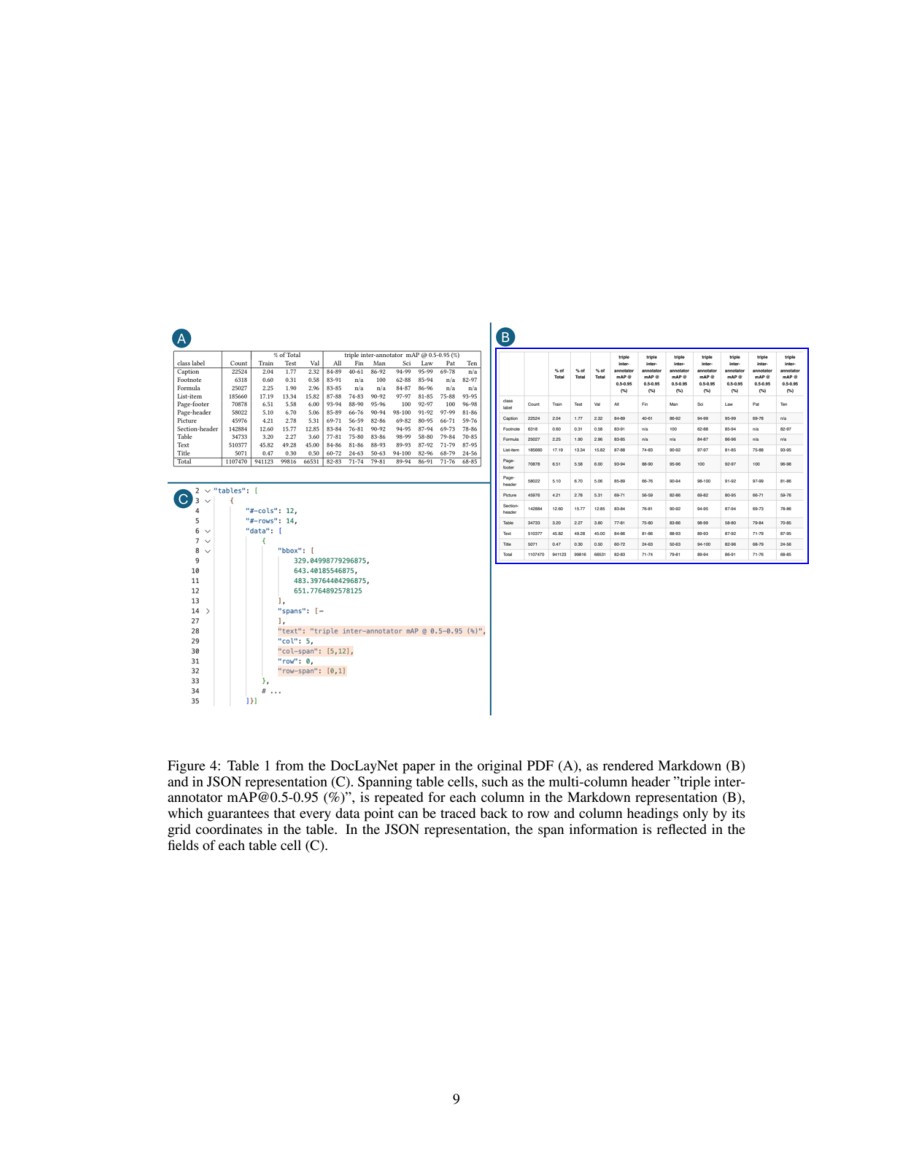


Source 2:
  text: "Baselines for Object Detection\nclass label,  = Count. class label, %of Total = Train. class label, %of Total = Test. class label, %of Total = Val. class label, triple inter- annotator mAP @ 0.5-0.95 (%) = All. class label, triple inter- annotator mAP @ 0.5-0.95 (%) = Fin. class label, triple inter- annotator mAP @ 0.5-0.95 (%) = Man. class label, t..."
  page: 9


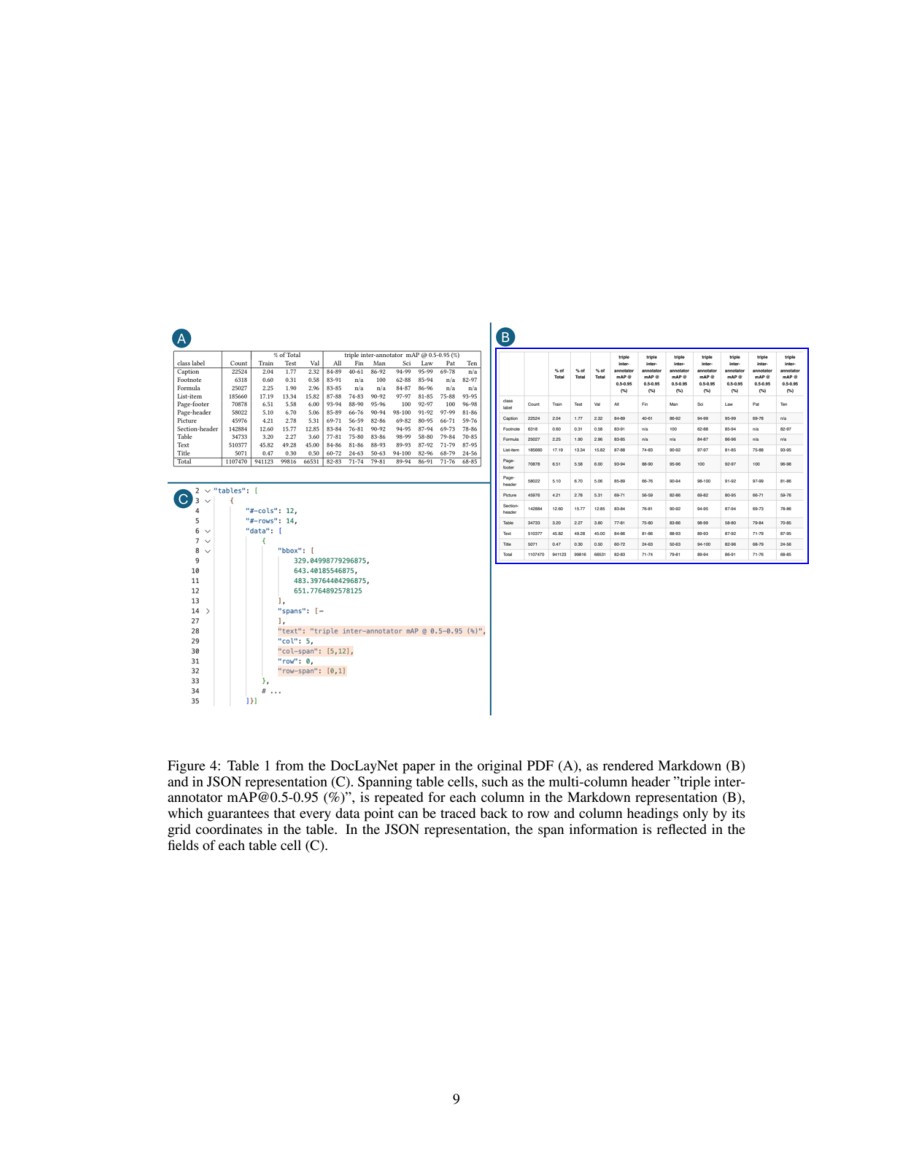


Source 3:
  text: "4 ANNOTATION CAMPAIGN\nCaption, Count = 22524. Caption, % of Total.Train = 2.04. Caption, % of Total.Test = 1.77. Caption, % of Total.Val = 2.32. Caption, triple inter-annotator mAP @0.5-0.95 (%).All = 84-89. Caption, triple inter-annotator mAP @0.5-0.95 (%).Fin = 40-61. Caption, triple inter-annotator mAP @0.5-0.95 (%).Man = 86-92. Caption, triple ..."
  page: 4


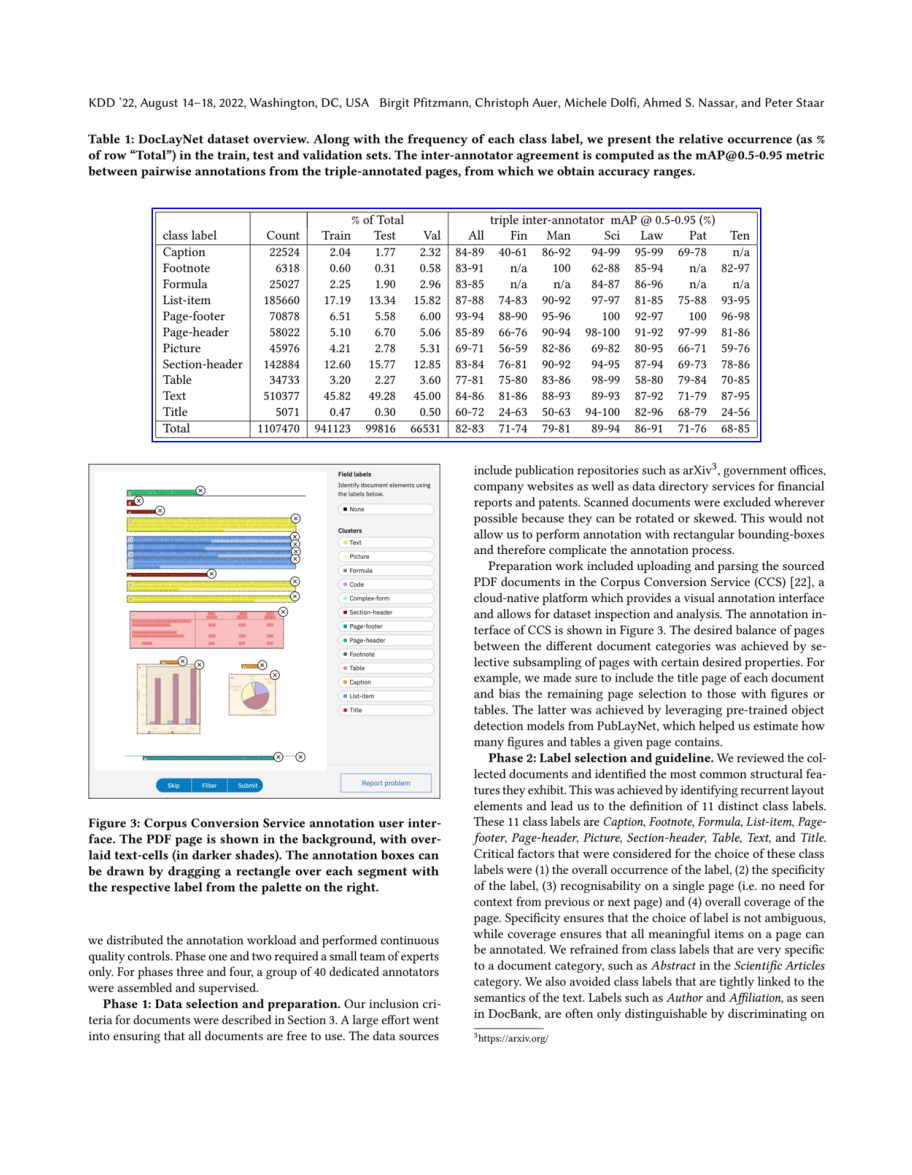

In [50]:
# Build response dictionary
resp_dict = {
    "input": query,
    "answer": response,
    "context": docs
}
print(f"Question:\n{resp_dict['input']}\n\nAnswer:\n{resp_dict['answer']}")

# --- Visualization Code (Docling Highlight) ---
for i, doc in enumerate(resp_dict["context"][:]):
    image_by_page = {}
    print(f"\nSource {i + 1}:")
    print(f"  text: {json.dumps(clip_text(doc.page_content, threshold=350))}")
    
    # Validate and load metadata
    meta = DocMeta.model_validate(doc.metadata["dl_meta"])

    # Load full DoclingDocument from the document store
    dl_doc = DoclingDocument.load_from_json(doc_store.get(meta.origin.binary_hash))

    for doc_item in meta.doc_items:
        if doc_item.prov:
            prov = doc_item.prov[0]  # Only using the first provenance item
            page_no = prov.page_no
            if img := image_by_page.get(page_no):
                pass
            else:
                page = dl_doc.pages[prov.page_no]
                print(f"  page: {prov.page_no}")
                img = page.image.pil_image
                image_by_page[page_no] = img

            # Draw bounding box
            bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
            bbox = bbox.normalized(page.size)
            thickness = 2
            padding = thickness + 2
            bbox.l = round(bbox.l * img.width - padding)
            bbox.r = round(bbox.r * img.width + padding)
            bbox.t = round(bbox.t * img.height - padding)
            bbox.b = round(bbox.b * img.height + padding)

            draw = ImageDraw.Draw(img)
            draw.rectangle(
                xy=bbox.as_tuple(),
                outline="blue",
                width=thickness,
            )

    # Display all images with highlights
    for p in image_by_page:
        img = image_by_page[p]
        plt.figure(figsize=[15, 15])
        plt.imshow(img)
        plt.axis("off")
        plt.show()

## Conclusion

In this notebook, we built a powerful and interpretable **Visual Grounding RAG Pipeline** by seamlessly integrating document understanding, semantic retrieval, and large language model reasoning.

1. **Semantic Retrieval**  
   We used a Milvus vector store to retrieve the most relevant document chunks based on a natural language query. This enabled fast and accurate context gathering for grounded question answering.

2. **Context-Aware Answering**  
   IBM watsonx.ai’s `Granite-3B` foundational model was used to generate rich, multi-step answers that align with the context retrieved—delivering responses that are both insightful and reliable.

3. **Visual Grounding with Docling**  
   Using `Docling`—an IBM project designed for intelligent document processing—we extracted metadata and bounding boxes to visually highlight the exact regions of source documents where the answer was found. This added a critical layer of explainability.

This pipeline lays a strong foundation for real-world applications in legal tech, finance, healthcare, and more—where trustworthy, explainable AI is essential.
